# Overview demonstration of OSMnx

OSMnx is a Python library that lets you download spatial geometries and construct, project, and visualize street networks from OpenStreetMap's API.

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx/tree/master/examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)

In [1]:
import osmnx as ox, geopandas as gpd
%matplotlib inline
ox.config(log_file=True, log_console=True, use_cache=True)

## Part 1: get shapefiles from OpenStreetMap

OSMnx lets you download spatial "place boundary" geometries from OpenStreetMap, save them to shapefiles, project them, and plot them. For a more in-depth demonstration of creating these shapefiles, see [this notebook](02-example-osm-to-shapefile.ipynb).

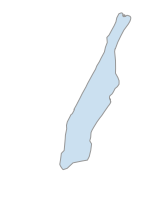

In [2]:
# get the boundary polygon for manhattan, save it as a shapefile, project it to UTM, and plot it
city = ox.gdf_from_place('Manhattan, New York City, New York, USA')
ox.save_gdf_shapefile(city)
city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(3,3))

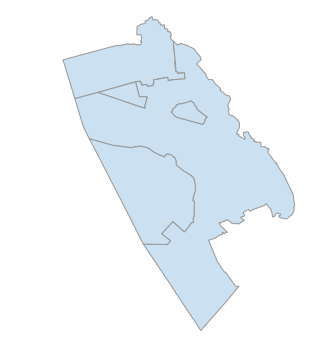

In [3]:
# get the boundary polygons for multiple cities, save as shapefile, project to UTM, and plot
place_names = ['Berkeley, California, USA', 
               'Oakland, California, USA',
               'Piedmont, California, USA',
               'Emeryville, California, USA',
               'Alameda, Alameda County, CA, USA']
east_bay = ox.gdf_from_places(place_names)
ox.save_gdf_shapefile(east_bay)
east_bay = ox.project_gdf(east_bay)
fig, ax = ox.plot_shape(east_bay)

## Part 2: download and construct street networks

OSMnx lets you download street network data and build topologically-corrected street networks, project and plot the networks, and save the street network as SVGs, GraphML files, or shapefiles for later use. The street networks are directed and preserve one-way directionality. For a more in-depth demonstration of creating street networks, see [this notebook](03-example-osm-place-network.ipynb).

You can download a street network by providing OSMnx any of the following (demonstrated in the examples below):
  - a bounding box
  - a lat-long point plus a distance
  - an address plus a distance
  - a place name or list of place names (to automatically geocode and get the boundary of)
  - a polygon of the desired street network's boundaries

You can also specify several different network types:
  - 'drive' - get drivable public streets (but not service roads)
  - 'drive_service' - get drivable streets, including service roads
  - 'walk' - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
  - 'bike' - get all streets and paths that cyclists can use
  - 'all' - download all non-private OSM streets and paths (this is the default network type unless you specify a different one)
  - 'all_private' - download all OSM streets and paths, including private-access ones

 #### Method #1, pass a bounding box ####
 This constructs the network from all the OSM nodes and ways within the bounding box.

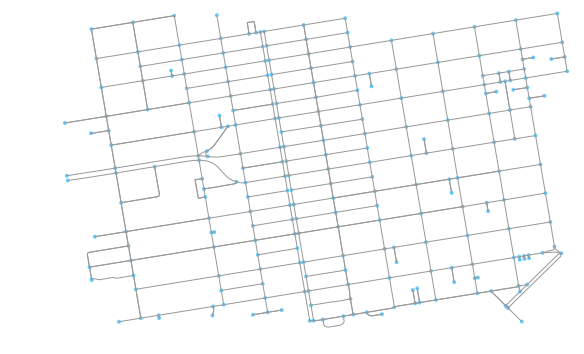

In [4]:
# define a bounding box in San Francisco
north, south, east, west = 37.79, 37.78, -122.41, -122.43

# create network from that bounding box
G1 = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')
G1 = ox.project_graph(G1)
fig, ax = ox.plot_graph(G1)

#### Method #2, pass a lat-long point and bounding box distance in meters#### 
This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box.

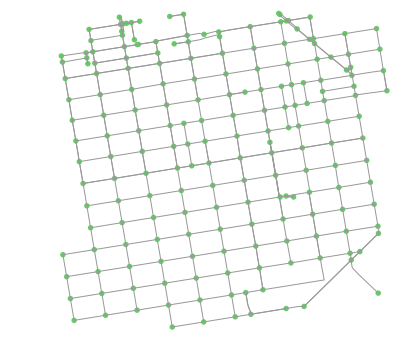

In [5]:
# define a point at the corner of California St and Mason St in SF
location_point = (37.791427, -122.410018)

# create network from point, inside bounding box of N, S, E, W each 750m from point
G2 = ox.graph_from_point(location_point, distance=750, distance_type='bbox', network_type='drive')
G2 = ox.project_graph(G2)
fig, ax = ox.plot_graph(G2, node_size=30, node_color='#66cc66')

#### Method #3, pass a (lat,lon) point and *network* distance in meters ####

This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box. Then it prunes the network by removing all nodes further than *n* meters from the point along the network.

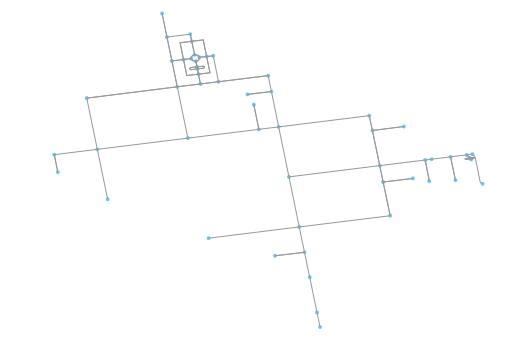

In [6]:
# same point again, but create network only of nodes within 500m along the network from point
G3 = ox.graph_from_point(location_point, distance=500, distance_type='network')
fig, ax = ox.plot_graph(G3)

*Note* the plot above shows the network within 500m (traveling distance along the network) from the `location_point`. By default, the `network_type` parameter value is 'all', meaning that we do not filter out paths that restrict certain types of traffic. This also means that one-way streets are honored as one-way and you cannot travel the wrong direction down them. Thus, the 500m takes into account only those nodes you can reach within 500m while only traveling in the allowed direction of the street. Instead (below), we can specify `network_type='walk'` to build a street network only of paths that walking is allowed on. This also makes every path bi-directional in the directed network, because you can walk in either direction on the sidewalk of a one-way street. Thus, the 500m now takes into account those nodes you can reach within 500m while traveling in either direction (even if it's a one-way street).

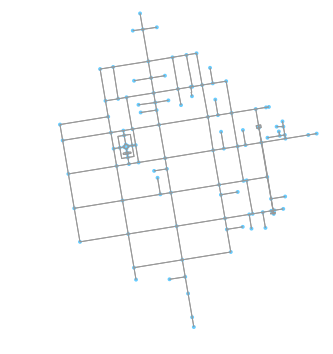

In [7]:
# create network only of nodes within 500m walking along the network from point
G3 = ox.graph_from_point(location_point, distance=500, distance_type='network', network_type='walk')
G3 = ox.project_graph(G3)
fig, ax = ox.plot_graph(G3)

#### Method #4, pass an address and distance (*bounding box* or *network*) in meters ####
This geocodes the address, creates a bounding box, downloads the network, then prunes it by network distance (if distance_type='network').

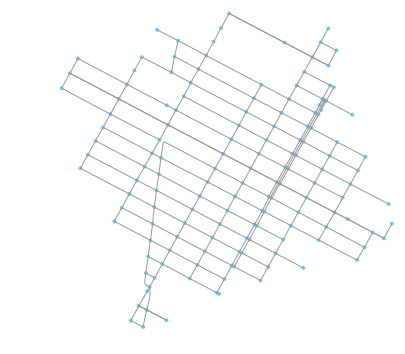

In [8]:
# network from address, including only nodes within 1km along the network from the address
G4 = ox.graph_from_address(address='350 5th Ave, New York, NY', 
                              distance=1000, distance_type='network', network_type='drive')

# you can project the network to UTM (zone calculated automatically)
G4_projected = ox.project_graph(G4)
fig, ax = ox.plot_graph(G4_projected)

#### Method #5, pass a place name ####

This geocodes the place name, gets the place's boundary shape polygon and bounding box, downloads the network within the bounding box, then prunes all nodes that lie outside the place's boundary polygon.

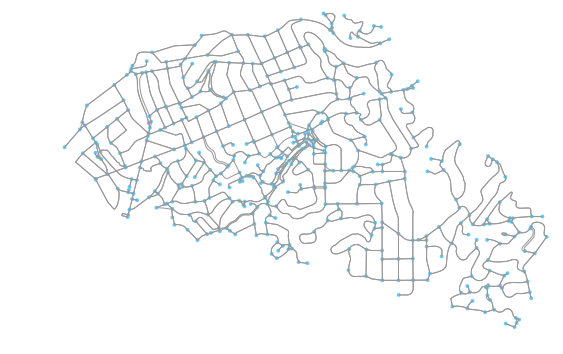

In [9]:
# create the street network within the city of Piedmont's borders
G5 = ox.graph_from_place('Piedmont, California, USA')
G5_projected = ox.project_graph(G5)
fig, ax = ox.plot_graph(G5_projected)

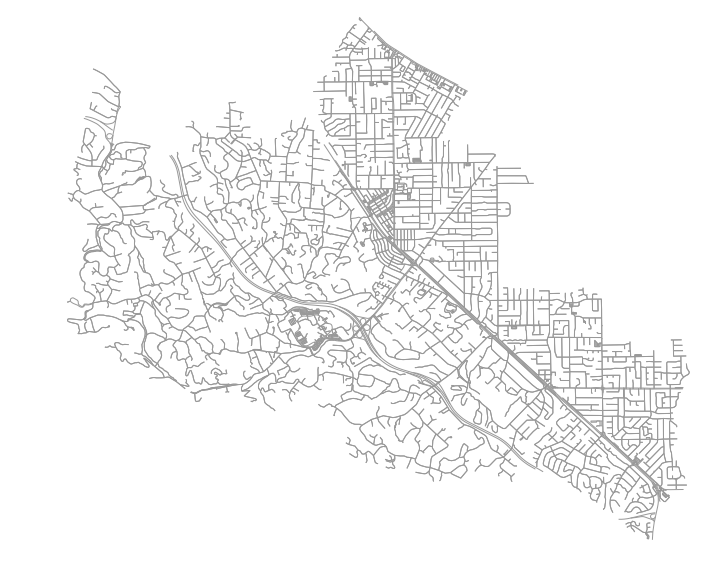

In [10]:
# you can also pass multiple places as a mixed list of strings and/or structured queries
places = ['Los Altos, California, USA',
          {'city':'Los Altos Hills', 'state':'California'},
          'Loyola, California']
G5 = ox.graph_from_place(places, clean_periphery=False)
G5_projected = ox.project_graph(G5)
fig, ax = ox.plot_graph(G5_projected, fig_height=10, node_size=0)
ox.save_graph_shapefile(G5, filename='false')

#### Method #6, pass a polygon ####

This example loads the [Mission District](http://www.zillow.com/howto/api/neighborhood-boundaries.htm)'s polygon from a shapefile, then downloads the network within its bounding box, then prunes all nodes that lie outside the place's boundary polygon.

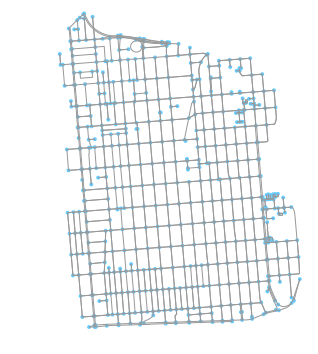

In [11]:
calif = gpd.read_file('input_data/ZillowNeighborhoods-CA')
mission_district = calif[(calif['CITY']=='San Francisco') & (calif['NAME']=='Mission')]
polygon = mission_district['geometry'].iloc[0]
G6 = ox.graph_from_polygon(polygon, network_type='drive_service')
G6_projected = ox.project_graph(G6)
fig, ax = ox.plot_graph(G6_projected)

## Part 3: simplifying street network topology

Simplification is normally done by OSMnx automatically under the hood, but we can break it out to see how it works. OpenStreetMap nodes are weird. They include intersections, but they also include all the points along a single block where the street curves. The latter are not nodes in the graph theory sense, so we remove them algorithmically and consolidate the set of edges between "true" network nodes into a single edge. There are two simplification modes, strict and non-strict. The main difference is that unlike strict mode, non-strict mode allows simplification to an "expansion graph" (ie, if the graph were undirected, nodes with degree 2 as long as the incident edges have different OSM IDs). For a more in-depth demonstration of topological simplification with OSMnx, see [this notebook](04-example-simplify-network.ipynb).

In [12]:
# create a network around some (lat, lon) point but do not simplify it yet
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, network_type='drive_service', distance=500, simplify=False)

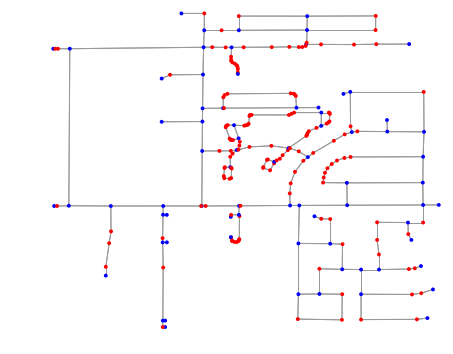

In [13]:
# turn off strict mode and see what nodes we'd remove, in red
nc = ['b' if ox.is_endpoint(G, node) else 'r' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=3)

The red and blue dots above are OSM nodes. We'll remove the nodes in red as they're not real network nodes.

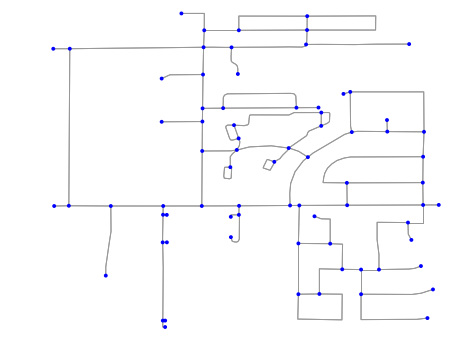

In [14]:
# simplify the network
G = ox.simplify_graph(G)
fig, ax = ox.plot_graph(G, node_color='b', node_zorder=3)

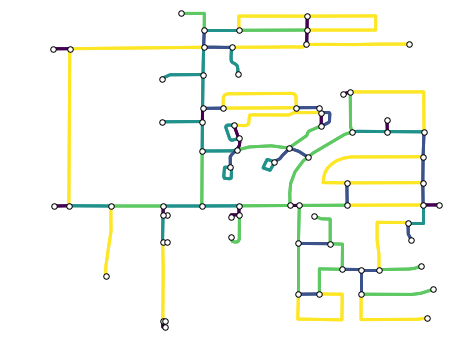

In [15]:
# show the simplified network with edges colored by edge length
ec = ox.get_edge_colors_by_attr(G, attr='length')
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color=ec, edge_linewidth=3)

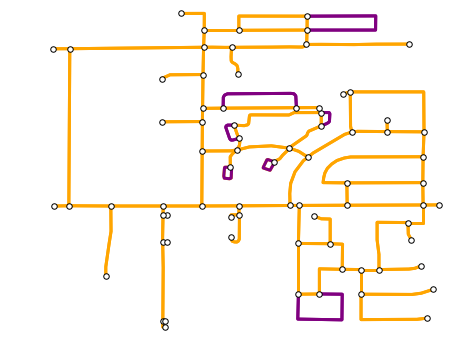

In [16]:
# highlight all parallel edges in purple
ec = ['orange' if key == 0 else 'purple' for u, v, key in G.edges(keys=True)]
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color=ec, edge_linewidth=3)

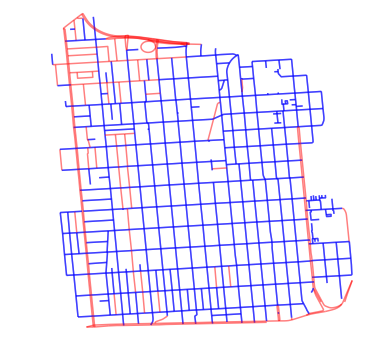

In [17]:
# highlight all the one-way edges in the mission district network from earlier
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in G6.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G6, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)

## Part 4: saving networks to disk

For more examples of saving and loading networks to/from disk, see [this notebook](05-example-save-load-networks-shapes.ipynb).

In [18]:
# save street network as ESRI shapefile to work with in GIS
ox.save_graph_shapefile(G, filename='network-shape')

In [19]:
# save street network as GraphML file to work with in networkx or gephi
ox.save_graphml(G, filename='network.graphml')

In [20]:
# save street network as SVG to work with in Adobe Illustrator
fig, ax = ox.plot_graph(G, show=False, save=True, filename='network', file_format='svg')

In [21]:
# get one of each network type and save to disk as image and shapefile
for nt in ['all_private', 'all', 'bike', 'walk', 'drive', 'drive_service']:
    G = ox.graph_from_address('N Sicily Pl, Chandler, AZ', network_type=nt, distance=1500)
    filename = 'az-{}'.format(nt)
    ox.save_graph_shapefile(G, filename=filename)
    fig, ax = ox.plot_graph(G, node_color='none', save=True, filename=filename, show=False)

For examples of working with these street networks in networkx, see [this example](06-example-osmnx-networkx.ipynb).

## Part 5: calculate basic network metrics

In [22]:
# calculate basic street network metrics and display average circuity
stats = ox.basic_stats(G)
stats['circuity_avg']

1.1170213197139203

In this street network, the streets are 11.7% more circuitous than the straight-lines paths would be.